In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from zipfile import ZipFile

In [105]:
ZipFile('gan-getting-started.zip', 'r').extractall(path = 'images')

In [163]:
def normalize(arr):
    return arr.astype(np.float32)/127.5 - 1

def denormalize(arr):
    return ((arr + 1)*127.5).astype(np.uint8)

In [164]:
def retrieve_images(dir, limit = None):
    images_list = [] 
    dir_list = os.listdir(dir)
    if(limit == None):
        limit = len(dir_list)
    for image in dir_list[0:limit]:
        images_list.append(normalize(np.asarray(Image.open(dir +'/' + image))))
    return pd.Series(images_list)

In [165]:
images = pd.DataFrame()
images['real_paintings'] = retrieve_images('images/monet_jpg')
images.head()

,real_paintings
0,"[[[0.41176474, 0.39607847, 0.09019613], [0.513..."
1,"[[[-0.88235295, -0.7176471, -0.8666667], [-0.4..."
2,"[[[0.39607847, 0.5372549, 0.6156863], [0.49019..."
3,"[[[0.254902, 0.28627455, 0.49803925], [0.27843..."
4,"[[[0.20784318, 0.09019613, -0.0745098], [0.278..."


In [4]:
len(images)

300

In [166]:
images['real_paintings'][0].dtype

dtype('float32')

In [168]:
denormalize(images['real_paintings'][0])

array([[[180, 178, 139],
        [193, 191, 153],
        [202, 202, 166],
        ...,
        [216, 204, 180],
        [203, 192, 164],
        [193, 179, 152]],

       [[184, 184, 148],
        [190, 190, 156],
        [196, 195, 164],
        ...,
        [218, 206, 182],
        [208, 194, 167],
        [196, 182, 155]],

       [[185, 185, 159],
        [185, 185, 159],
        [187, 187, 163],
        ...,
        [224, 212, 188],
        [215, 201, 175],
        [204, 190, 163]],

       ...,

       [[156, 140, 115],
        [191, 177, 151],
        [196, 184, 160],
        ...,
        [155,  89,  30],
        [143,  72,  15],
        [139,  64,   8]],

       [[154, 136, 122],
        [197, 180, 164],
        [199, 186, 169],
        ...,
        [136,  96,  25],
        [141,  96,  27],
        [131,  84,  15]],

       [[147, 127, 118],
        [185, 167, 155],
        [200, 184, 171],
        ...,
        [113,  87,   9],
        [121,  94,  16],
        [114,  87,   9]]

In [173]:
Image.fromarray(denormalize(images['real_paintings'][0])).show()

In [172]:
Image.fromarray(denormalize(np.rot90(images['real_paintings'][0], 3))).show()

In [171]:
Image.fromarray(denormalize(np.rot90(np.flip(np.flip(images['real_paintings'][0],0), 1), 3))).show()

In [5]:
def extend_data_by_flipping(image_series):
    flipped_image_list = []
    for i in range(0, len(image_series)):
        image = image_series[i]
        flipped_image_list.append(np.flip(image, 0))
        flipped_image_list.append(np.flip(image, 1))
        flipped_image_list.append(np.flip(np.flip(image, 0), 1))
        flipped_image_list.append(np.rot90(image))
        flipped_image_list.append(np.rot90(image, 3))
        flipped_image_list.append(np.flip(np.rot90(image), 0))
        flipped_image_list.append(np.flip(np.rot90(image), 1))
        flipped_image_list.append(np.flip(image, -1))
        flipped_image_list.append(np.flip(np.flip(image, 0), -1))
        flipped_image_list.append(np.flip(np.flip(image, 1), -1))
        flipped_image_list.append(np.flip(np.flip(np.flip(image, 0), 1), -1))
        flipped_image_list.append(np.flip(np.rot90(image), -1))
        flipped_image_list.append(np.flip(np.rot90(image, 3), -1))
        flipped_image_list.append(np.flip(np.flip(np.rot90(image), 0), -1))
        flipped_image_list.append(np.flip(np.flip(np.rot90(image), 1), -1))
    return pd.Series(flipped_image_list)

In [169]:
images = pd.concat([images, pd.DataFrame({'real_paintings' : extend_data_by_flipping(images['real_paintings'])})], ignore_index = True)
len(images)

4800

In [170]:
Image.fromarray(denormalize(images['real_paintings'][313])).show()

In [174]:
images['images_to_transform'] = retrieve_images('images/photo_jpg', limit = 4800)
images.head()

,real_paintings,images_to_transform
0,"[[[0.41176474, 0.39607847, 0.09019613], [0.513...","[[[-0.11372548, -0.1372549, -0.20784312], [-0...."
1,"[[[-0.88235295, -0.7176471, -0.8666667], [-0.4...","[[[-1.0, -0.5294118, -0.2862745], [-0.9843137,..."
2,"[[[0.39607847, 0.5372549, 0.6156863], [0.49019...","[[[-0.58431375, -0.5372549, -0.64705884], [-0...."
3,"[[[0.254902, 0.28627455, 0.49803925], [0.27843...","[[[-0.38039213, -0.32549018, -0.24705881], [-0..."
4,"[[[0.20784318, 0.09019613, -0.0745098], [0.278...","[[[0.027451038, 0.35686278, 0.5294118], [0.019..."


In [175]:
Image.fromarray(denormalize(images['images_to_transform'][0])).show()

In [205]:
images['images_to_transform'][0].dtype

dtype('float32')

In [176]:
images['real_paintings'][0].reshape((1, 256, 256, 3))

array([[[[ 0.41176474,  0.39607847,  0.09019613],
         [ 0.5137255 ,  0.49803925,  0.20000005],
         [ 0.58431375,  0.58431375,  0.30196083],
         ...,
         [ 0.69411767,  0.6       ,  0.41176474],
         [ 0.5921569 ,  0.5058824 ,  0.28627455],
         [ 0.5137255 ,  0.4039216 ,  0.19215691]],

        [[ 0.4431373 ,  0.4431373 ,  0.16078436],
         [ 0.4901961 ,  0.4901961 ,  0.22352946],
         [ 0.5372549 ,  0.5294118 ,  0.28627455],
         ...,
         [ 0.70980394,  0.6156863 ,  0.427451  ],
         [ 0.6313726 ,  0.52156866,  0.30980396],
         [ 0.5372549 ,  0.427451  ,  0.21568632]],

        [[ 0.45098042,  0.45098042,  0.24705887],
         [ 0.45098042,  0.45098042,  0.24705887],
         [ 0.4666667 ,  0.4666667 ,  0.27843142],
         ...,
         [ 0.75686276,  0.6627451 ,  0.47450984],
         [ 0.6862745 ,  0.5764706 ,  0.37254906],
         [ 0.6       ,  0.4901961 ,  0.27843142]],

        ...,

        [[ 0.22352946,  0.09803927, -0

In [11]:
for i in range(0, 5):
    print(images['real_paintings'][i].shape)
    print(images['images_to_transform'][i].shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
def downsample(in_channels, out_channels, kernel_size, norm_type = 'batchnorm', apply_norm = True):
  #initializer = tf.random_normal_initializer(0., 0.02)

  result = append.Sequential()
  result.append(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides=2, padding='same',
                             bias=False))
  if(apply_norm):
      if(norm_type.lower() == 'batchnorm'):
          result.append(nn.BatchNorm2d(out_channels))
      elif(norm_type.lower() == 'instancenorm'):          
          result.append(nn.InstanceNorm2d(out_channels))

  result.append(nn.LeakyRelu(0.3))

  return result

In [ ]:
def upsample(in_channels, out_channels, kernel_size, norm_type = 'batch_norm', apply_dropout = False):
  #initializer = tf.random_normal_initializer(0., 0.02)

  result = nn.Sequential()
  result.append(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides=2,
                                      padding='same',
                                      bias=False))
  
  if(norm_type.lower() == 'batchnorm'):
      result.append(nn.BatchNorm2d(out_channels))
  elif(norm_type.lower() == 'instancenorm'):          
      result.append(nn.InstanceNorm2d(out_channels))

  if apply_dropout:
    result.append(nn.Dropout())

  result.append(nn.ReLU())

  return result

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_channels, output_channels, norm_type = 'batch_norm'):
        super(Generator, self).__init__()
        self.down_stack = [
            downsample(input_channels, 64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
            downsample(64, 128, 4, norm_type),  # (bs, 64, 64, 128)
            downsample(128, 256, 4, norm_type),  # (bs, 32, 32, 256)
            downsample(256, 512, 4, norm_type),  # (bs, 16, 16, 512)
            downsample(512, 512, 4, norm_type),  # (bs, 8, 8, 512)
            downsample(512, 512, 4, norm_type),  # (bs, 4, 4, 512)
            downsample(512, 512, 4, norm_type),  # (bs, 2, 2, 512)
            downsample(512, 512, 4, norm_type),  # (bs, 1, 1, 512)
        ]
        self.up_stack = [
            upsample(512, 512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
            upsample(512, 512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
            upsample(512, 512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
            upsample(512, 512, 4, norm_type),  # (bs, 16, 16, 1024)
            upsample(512, 256, 4, norm_type),  # (bs, 32, 32, 512)
            upsample(256, 128, 4, norm_type),  # (bs, 64, 64, 256)
            upsample(128, 64, 4, norm_type),  # (bs, 128, 128, 128)
        ]
        self.last = nn.ConvTranspose2d(64, output_channels, 4, strides=2,
                                      padding='same',
                                      bias=False)

    def forward(self, z):
        x = None
        for down in self.down_stack:
            x = down(x)
        for up in self.up_stack:
            x = up(x)
        return torch.tanh(self.last(x)) 

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, input_channels, norm_type = 'batch_norm'):
        super(Discriminator, self).__init__()
        self.down_stack = [downsample(input_channels, 64, 4, 
                                      norm_type, downsample(64, 128, 4, norm_type, False),
                                      downsample(128, 256, 4, norm_type, False)}
        self.model = nn.Sequential()
        self.model.append(nn.ZeroPad2d(1))
        self.model.append(nn.Conc2d(128, 512, 4, strides=1, bias = False))

        if(norm_type.lower() == 'batchnorm'):
            self.model.append(nn.BatchNorm2d(512))
        elif(norm_type.lower() == 'instancenorm'):          
            self.model.append(nn.InstanceNorm2d(512))

        self.model.append(nn.LeakyRelu())
        self.model.append(nn.ZeroPad2d(1))
        self.model.append(nn.Conv2d(512, 1, 4, strides=1))

    def forward(self, z):
        x= None
        for down in self.down_stack:
            x  = down(z)
        return self.model(x)

In [33]:
#loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_obj = nn.BCELoss()

In [34]:
def discriminator_loss(real, generated):
  #return (loss_obj(tf.ones_like(real), real) + loss_obj(tf.zeros_like(generated), generated)) * 0.5
  return (loss_obj(torch.ones_like(real), real) + loss_obj(torch.zeros_like(generated), generated)) * 0.5

In [35]:
def generator_loss(generated):
  #return loss_obj(tf.ones_like(generated), generated)
  return loss_obj(torch.ones_like(generated), generated)

In [36]:
LAMBDA = 10

In [37]:
def calc_cycle_loss(real_image, cycled_image):
  #return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * tensor.mean(tensor.abs(real_image - cycled_image))

In [38]:
def identity_loss(real_image, same_image):
  #return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * tensor.mean(tensor.abs(real_image - same_image))

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = Generator(24, OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = Generator(24, OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = Discriminator(24, norm_type='instancenorm', target=False)
discriminator_y = Discriminator(24, norm_type='instancenorm', target=False)

In [ ]:
generator_g_optimizer = optim.Adam(generator_g.parameters(), lr = 2e-4, betas=0.5)
generator_f_optimizer = optim.Adam(generator_f.parameters(), lr = 2e-4, betas=0.5)

discriminator_x_optimizer = optim.Adam(discriminator_x.parameters(), lr = 2e-4, betas=0.5)
discriminator_y_optimizer = optim.Adam(discriminator_y.parameters(), lr = 2e-4, betas=0.5)

In [ ]:
gen_g_scaler = torch.cuda.amp.GradScaler()
gen_f_scaler = torch.cuda.amp.GradScaler()
disc_x_scaler = torch.cuda.amp.GradScaler()
disc_y_scaler = torch.cuda.amp.GradScaler()

In [177]:
def generate_images(model, test_input):
    prediction = model(test_input.reshape((1, 256, 256, 3))).numpy().reshape((256, 256, 3))
    return Image.fromarray(denormalize(prediction))

In [21]:
sample_image = np.asarray(Image.open('images/photo_jpg/' + os.listdir('images/photo_jpg/')[4801]))
sample_image.shape

(256, 256, 3)

In [23]:
Image.fromarray(sample_image).show()

In [76]:
np.array([[1,2,3],[4,5,6],[7,8,9]], dtype = np.float32)*128 + 128

array([[ 256.,  384.,  512.],
       [ 640.,  768.,  896.],
       [1024., 1152., 1280.]], dtype=float32)

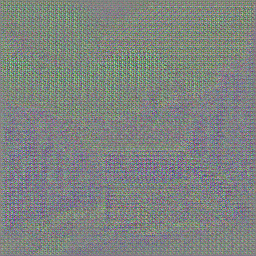

In [181]:
generate_images(generator_g, normalize(sample_image))

In [141]:
round(9/2) + (9%2>0)

5

In [143]:
batch_of_images = np.zeros((24, 256, 256, 3))
for i in range(0, 24):
    batch_of_images[i] = images['real_paintings'][i]
batch_of_images.shape

(24, 256, 256, 3)

In [191]:
indices = np.arange(len(images))
indices

array([   0,    1,    2, ..., 4797, 4798, 4799])

In [226]:
np.random.shuffle(indices)
indices[0].item()

1434

In [220]:
def retrieve_batch(starting_point, batch_size, indices, data):
    limit = batch_size
    if((len(data) - starting_point)<batch_size):
        limit = len(data) - starting_point
    batch = np.zeros((limit, 256, 256, 3), dtype = np.float32)
    for i in range(0, limit):
        batch[i] = data[indices[starting_point + i].item()]
    return batch

In [228]:
retrieve_batch(4790, 24, indices, images['real_paintings'])

array([[[[-0.49019605, -0.24705881,  0.18431377],
         [-0.6627451 , -0.44313723,  0.03529418],
         [-0.69411767, -0.56078434,  0.07450986],
         ...,
         [-0.38039213, -0.372549  , -0.40392154],
         [-0.40392154, -0.41176468, -0.49019605],
         [-0.4352941 , -0.4352941 , -0.54509807]],

        [[-0.6       , -0.47450978,  0.22352946],
         [-0.67058825, -0.56078434,  0.09019613],
         [-0.6627451 , -0.5686275 ,  0.07450986],
         ...,
         [-0.5294118 , -0.40392154, -0.27058822],
         [-0.52156866, -0.3960784 , -0.30196077],
         [-0.5686275 , -0.44313723, -0.38823527]],

        [[-0.6156863 , -0.6862745 ,  0.41960788],
         [-0.6313726 , -0.6784314 ,  0.23921573],
         [-0.6       , -0.5921569 ,  0.09803927],
         ...,
         [-0.6156863 , -0.32549018,  0.0196079 ],
         [-0.56078434, -0.27843136,  0.0196079 ],
         [-0.62352943, -0.3490196 , -0.08235294]],

        ...,

        [[ 1.        ,  0.9529412 ,  0

In [ ]:
def train_step(real_x, real_y):
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    with torch.cuda.amp.autocast():
        fake_y = generator_g(real_x)
        cycled_x = generator_f(fake_y)

        fake_x = generator_f(real_y)
        cycled_y = generator_g(fake_x)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x)
        same_y = generator_g(real_y)

        disc_real_x = discriminator_x(real_x)
        disc_real_y = discriminator_y(real_y

        disc_fake_x = discriminator_x(fake_x)
        disc_fake_y = discriminator_y(fake_y)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_optimizer.zero_grad()
    gen_g_scaler.scale(total_gen_g_loss).backward()
    gen_g_scaler.step(generator_g_optimizer)
    gen_g_scaler.update()

    generator_f_optimizer.zero_grad()
    gen_f_scaler.scale(total_gen_f_loss).backward()
    gen_f_scaler.step(generator_f_optimizer)
    gen_f_scaler.update()

    discriminator_x_optimizer.zero_grad()
    disc_x_scaler.scale(disc_x_loss).backward()
    disc_x_scaler.step(discriminator_x_optimizer)
    disc_x_scaler.update()

    discriminator_y_optimizer.zero_grad()
    disc_y_scaler.scale(disc_y_loss).backward()
    disc_y_scaler.step(discriminator_y_optimizer)
    disc_y_scaler.update()

In [110]:
import time
from IPython.display import clear_output

In [149]:
batch_size = 24
num_of_batches = round(len(images)/batch_size) + (len(images)%batch_size>0)

In [210]:
for epoch in range(10):
  start = time.time()

  np.random.shuffle(indices)
  #n = 0    
  for i in range(0, num_of_batches):
    images_x = retrieve_batch(i*batch_size, batch_size, indices, images['real_paintings'])#.astype(np.float32)
    images_y = retrieve_batch(i*batch_size, batch_size, indices, images['images_to_transform'])#.astype(np.float32)
    print(images_x.dtype)
    print(images_y.dtype)
    train_step(images_x, images_y)
    if i % 25 == 0:
      print ('Epoch ' + str(epoch + 1) + '. ' + str((i+1)*batch_size) + ' records processed.')
    #n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_image) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_image).show()

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

float64
float64


KeyboardInterrupt: 

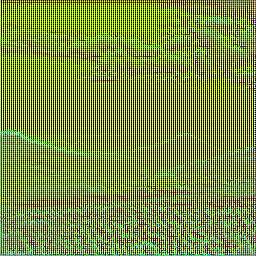

In [151]:
generate_images(generator_g, images['images_to_transform'][0])